# PyTorch Layer 이해하기

### 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./dataset', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size=1)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

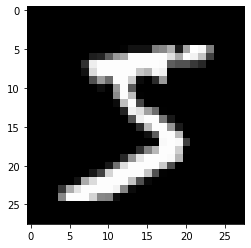

In [6]:
plt.imshow(image[0, 0, :, :], 'gray')
plt.show()

### 각 Layer별 설명 

#### Network 쌓기 위한 준비

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Convolution 

* in_channels: 받게 될 channel의 갯수
* out_channels: 보내고 싶은 channel의 갯수
* kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [8]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [9]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

* weight 시각화를 위해 slice하고 numpy화

In [10]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

* 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
* detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [11]:
weight = weight.detach().numpy()
weight.shape

(20, 1, 5, 5)

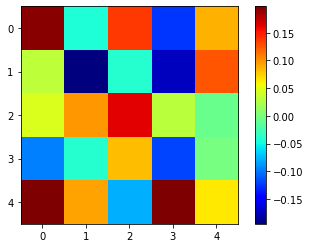

In [12]:
plt.imshow(weight[0, 0, :, :], 'jet')
plt.colorbar()
plt.show()

* output 시각화 준비를 위해 numpy화

In [13]:
output_data = layer(image).data

In [14]:
output = output_data.cpu().numpy()

In [15]:
output.shape

(1, 20, 24, 24)

* input으로 들어간 이미지 numpy화

In [16]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

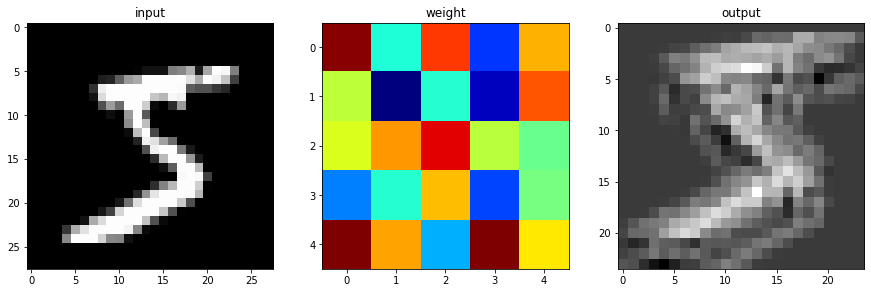

In [17]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')

plt.subplot(132)
plt.title('weight')
plt.imshow(weight[0, 0, :, :], 'jet')

plt.subplot(133)
plt.title('output')
plt.imshow(output[0, 0, :, :], 'gray')

plt.show()

### Pooling 

* input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [18]:
image.shape

torch.Size([1, 1, 28, 28])

In [19]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

* MaxPool Layer는 weight가 없기 떄문에 바로 numpy()가 가능

In [20]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [21]:
image_arr.shape

(1, 1, 28, 28)

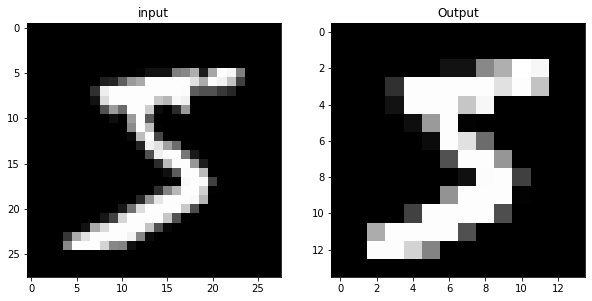

In [22]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')

plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')

plt.show()

### Linear 

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [23]:
flatten = image.view(1, 28 * 28)
flatten.shape

torch.Size([1, 784])

In [24]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [25]:
lin

tensor([[-0.3183, -0.1988,  0.2826, -0.1137, -0.0086, -0.1070,  0.1789, -0.0338,
         -0.1661,  0.2638]], grad_fn=<AddmmBackward>)

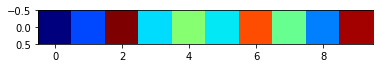

In [26]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

### Softmax 

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [27]:
with torch.no_grad():
    flatten = image.view(1, 28 * 28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

In [28]:
softmax

tensor([[0.0874, 0.1137, 0.1118, 0.0647, 0.1061, 0.1244, 0.0909, 0.1016, 0.0820,
         0.1173]])

In [29]:
np.sum(softmax.numpy())

1.0000001

### Layer 쌓기 

nn과 nn.functional의 차이점

* nn은 학습 파라미터가 담긴 것
* nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [45]:
class Net(nn.Module):
    def __init__(self):
        # 학습이 가능한 것
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # in, out, kernel, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # kernel, stride
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        #print(x.shape)
        # Fully Connected
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

* Image를 Model에 넣어서 결과 확인

In [46]:
model = Net()

In [47]:
result = model.forward(image)

In [48]:
result

tensor([[-2.3367, -2.2796, -2.3290, -2.3244, -2.3335, -2.2860, -2.2543, -2.2892,
         -2.2923, -2.3041]], grad_fn=<LogSoftmaxBackward>)

In [51]:
model.conv1

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [52]:
model.conv1(image)

tensor([[[[-0.1403, -0.1403, -0.1403,  ..., -0.1403, -0.1403, -0.1403],
          [-0.1403, -0.1403, -0.1403,  ...,  0.1254,  0.0286, -0.0731],
          [-0.1403, -0.1403, -0.1403,  ...,  0.1854,  0.0100, -0.1038],
          ...,
          [-0.1911, -0.1697, -0.1060,  ..., -0.1403, -0.1403, -0.1403],
          [-0.0638, -0.0436, -0.2218,  ..., -0.1403, -0.1403, -0.1403],
          [-0.1563, -0.2550, -0.2797,  ..., -0.1403, -0.1403, -0.1403]],

         [[-0.0258, -0.0258, -0.0258,  ..., -0.0258, -0.0258, -0.0258],
          [-0.0258, -0.0258, -0.0258,  ...,  0.1612,  0.1860,  0.0572],
          [-0.0258, -0.0258, -0.0258,  ...,  0.1991,  0.0502, -0.0695],
          ...,
          [-0.0905, -0.1589, -0.0964,  ..., -0.0258, -0.0258, -0.0258],
          [-0.1523, -0.2110, -0.0821,  ..., -0.0258, -0.0258, -0.0258],
          [-0.0689, -0.0310, -0.0077,  ..., -0.0258, -0.0258, -0.0258]],

         [[-0.0707, -0.0707, -0.0707,  ..., -0.0707, -0.0707, -0.0707],
          [-0.0707, -0.0707, -